In [54]:
import os
from langchain_openai import ChatOpenAI
from pydantic import BaseModel


def get_llm_reasoner_model():
    return ChatOpenAI(
        model="DeepSeek-R1-Distill-Qwen-14B",
        base_url="https://chatapi.akash.network/api/v1",
        api_key=os.environ.get("AKASH_API_KEY"),
        temperature=0.6,
    )


def get_llm_structured_output(schema: BaseModel):
    llm = ChatOpenAI(
        model="Meta-Llama-3-3-70B-Instruct",
        base_url=(
            "https://chatapi.akash.network"
            "/api/v1"
        ),
        api_key=os.getenv("AKASH_API_KEY"),
        temperature=0
    )

    return llm.with_structured_output(schema)


def extract_result_from_tags(tag: str, result: str):
    if "</think>" in result:
        result = result.split("</think>")[1]

    if f"<{tag}>" in result:
        return result.split(f"<{tag}>")[1].split(f"</{tag}>")[0]

    return result


def extract_result_from_tags(tag: str, result: str):
    if "</think>" in result:
        result = result.split("</think>")[1]

    if f"<{tag}>" in result:
        return result.split(f"<{tag}>")[1].split(f"</{tag}>")[0]

    return result

In [55]:
import operator
from typing import Optional, TypedDict
from pydantic import BaseModel, Field
from typing_extensions import Annotated


class BlogSection(BaseModel):
    title: str = Field(..., title="Title of the blog section")
    description: str = Field(
        ..., title="Description of the blog section. Briefly describe what the section is about, concepts covered and main topics.")
    base_content: Optional[str] = Field(
        None, title="Base content of the blog section. This is part of the content the user has provided and its related to this section.")
    research: str = Field(..., title="Research content of the blog section. This is the content that the AI has generated and is related to this section.")
    research_queries: list[str] = Field(
        ..., title="Research queries of the blog section. This is the list of queries that the AI will use to generate the research content.")
    content: str = Field(..., title="Content of the blog section. This is the final content that will be displayed in the blog section.")

class ExpectedStructuredOutput(BaseModel):
    sections: list[BlogSection] = Field(
        ..., title="List of blog sections. Each section contains the title, description, base content, research content, research queries and final content.")

class InputState(TypedDict):
    topic: str
    base_file: Optional[str]


class OutputState(TypedDict):
    sections: Annotated[list[BlogSection], operator.add]


class OverallState(InputState, OutputState):
    user_feedback: Optional[str]

In [56]:
SECTIONS_PLANNER_PROMPT = """
<GOAL>
I want to create a blog post about the topic of "{topic}" and I need you to give the sections of the blog post.

Each section should have the fields:

- Title - Title of the blog section
- Description - Briefly describe what the section is about, concepts covered and main topics.
- Research queries - Research queries of the blog section. This is the list of queries that the AI will use to generate the research content.
- Base content - Base content of the blog section. This is part of the content the user has provided (if any) and its related to this section.

For example, introduction and conclusion will not require research because they will distill information from other parts of the report.


The user has provided the following base content (if any):
{base_file}

The user has provided this feedback (if any):
{feedback}

The feedback is about this previously generated sections (if any):
{previous_sections}
</GOAL> 

<RETURN FORMAT>
An array of sections with the following fields:
""" + \
    f"{str(BlogSection.model_json_schema()['properties']).replace('{', '{{').replace('}', '}}')}" + \
    """
</RETURN FORMAT>
"""

In [69]:
from typing_extensions import Literal
from langgraph.types import interrupt
from langgraph.graph import END


def generate_blog_sections(state: OverallState):
    reasoner_model = get_llm_reasoner_model()
    prompt = SECTIONS_PLANNER_PROMPT.format(
        topic=state["topic"],
        base_file=state.get("base_file", ""),
        feedback=state.get("feedback", ""),
        previous_sections=state.get("sections", "")
    )

    blog_sections_output = get_llm_structured_output(ExpectedStructuredOutput)

    result = reasoner_model(prompt).content
    structured_output: ExpectedStructuredOutput = blog_sections_output.invoke(result)

    print(structured_output.sections)
    return {"sections": structured_output.sections}


def get_feedback_from_sections(state: OverallState):
    # Get sections
    sections = state['sections']
    sections_str = "\n\n".join(
        f"Section: {section.title}\n"
        f"Description: {section.description}\n"
        f"Research queries: {section.research_queries if section.research_queries else ''}\n"
        f"Base content: {section.base_content if section.base_content else ''}\n"
        for section in sections
    )

    print(sections_str)

    # Get feedback on the report plan from interrupt
    # feedback = interrupt(f"""Please provide feedback on the following report plan.\n
    #                      {sections_str}\n\n 
    #                      Does the report plan meet your needs? \n
    #                      Say "yes" to approve the report plan or provide feedback to regenerate the report plan:
    #                      """)
    feedback ="yes"

    return {"user_feedback": feedback}


def human_feedback_router(state: OverallState) -> Literal["REGENERATE", "APPROVED"]:
    if state["user_feedback"].lower().startswith("yes"):
        return "APPROVED"

    return "REGENERATE"

In [70]:
from langgraph.graph import START, END, StateGraph


def get_workflow():
    graph_builder = StateGraph(
        OverallState, input=InputState, output=OutputState)

    graph_builder.add_node("generate_blog_sections", generate_blog_sections)
    graph_builder.add_node("get_feedback_from_sections",
                           get_feedback_from_sections)

    graph_builder.add_edge(START, "generate_blog_sections")
    graph_builder.add_edge("generate_blog_sections",
                           "get_feedback_from_sections")
    graph_builder.add_conditional_edges("get_feedback_from_sections",
                                        human_feedback_router,
                                        {
                                            "REGENERATE": "generate_blog_sections",
                                            "APPROVED": END
                                        })

    return graph_builder.compile()

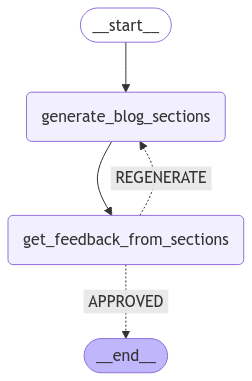

In [71]:
from IPython.display import Image, display
workflow = get_workflow()

# View
display(Image(workflow.get_graph().draw_mermaid_png()))

In [ ]:
await workflow.ainvoke({"topic": 'Quantum Computing', 
                        "base_file": 'Quantum Computing is a field of computing that leverages the principles of quantum mechanics to perform operations on data. Quantum computers are able to perform calculations that are impossible for classical computers. Quantum computing is a rapidly growing field with many potential applications in areas such as cryptography, optimization, and machine learning.'})

[BlogSection(title='Introduction', description='An introduction to quantum computing, its significance, and potential impact on various fields.', base_content='Quantum Computing is a field of computing that leverages the principles of quantum mechanics to perform operations on data. Quantum computers are able to perform calculations that are impossible for classical computers. Quantum computing is a rapidly growing field with many potential applications in areas such as cryptography, optimization, and machine learning.', research='', research_queries=['What is quantum computing?', 'What are the principles of quantum mechanics?', 'What are the potential applications of quantum computing?'], content='Quantum computing represents a revolutionary leap in technology, harnessing the fundamental principles of quantum mechanics to perform computations that are infeasible for classical computers. This emerging field promises to transform industries, from cryptography to healthcare, by solving c

{'sections': [BlogSection(title='Introduction', description='An introduction to quantum computing, its significance, and potential impact on various fields.', base_content='Quantum Computing is a field of computing that leverages the principles of quantum mechanics to perform operations on data. Quantum computers are able to perform calculations that are impossible for classical computers. Quantum computing is a rapidly growing field with many potential applications in areas such as cryptography, optimization, and machine learning.', research='', research_queries=['What is quantum computing?', 'What are the principles of quantum mechanics?', 'What are the potential applications of quantum computing?'], content='Quantum computing represents a revolutionary leap in technology, harnessing the fundamental principles of quantum mechanics to perform computations that are infeasible for classical computers. This emerging field promises to transform industries, from cryptography to healthcare,